# Modèles de prédiction pour la variable cible : **TotalGHGEmissions**

Cette variable exprime la quantité totale d'émissions de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et les gaz d'oxyde nitreux libérés dans l'atmosphère à la suite de la consommation d'énergie de la propriété, mesurée en tonnes métriques d'équivalent dioxyde de carbone. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources de production de Seattle City Light. Cela utilise le facteur d'émissions 2015 de Seattle City Light de 52,44 lb CO2e/MWh jusqu'à ce que le facteur 2016 soit disponible. Facteur de vapeur Enwave = 170,17 lb CO2e/MMBtu. Facteur de gaz provenant de EPA Portfolio Manager = 53,11 kg CO2e/MBtu.

* [Préparer les données pour les algorithmes de Machine Learning](#Préparer-les-données-pour-les-algorithmes-de-Machine-Learning)
* [Partie 1 : Séléction et entraînement des modèles de régression](#Partie-1-:-Séléction-et-entraînement-des-modèles-de-régression)
* [Partie 2 : Mesure de l'importance des variables](#Partie-2-:-Mesure-de-l'importance-des-variables)
* [Partie 3 : Influence de la variable **EneergieStarScore**](#Partie-3-:-Influence-de-la-variable-EneergieStarScore)
* [Partie 4 : Entraînement du meilleur estimateur avec y_TotalGHGEmissions_log2](
#Partie-4-:-Entraînement-du-meilleur-estimateur-avec-y_TotalGHGEmissions_log2)

In [2]:
import pandas as pd
import numpy as np

In [3]:
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [4]:
from sklearn import neighbors, metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

In [5]:
import timeit

In [6]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px

In [7]:
from sklearn.preprocessing import StandardScaler

from sklearn import dummy

from sklearn import model_selection
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import kernel_ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn import kernel_ridge

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVR

In [8]:
from sklearn.decomposition import PCA
from sklearn import decomposition

In [9]:
import shap

In [10]:
from sklearn.model_selection import learning_curve

- Fonctions utiles

In [11]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [12]:
def rmse(modele,X,y):
    emission_predictions = modele.predict(X)
    lin_mse = mean_squared_error(y, emission_predictions)
    return np.sqrt(lin_mse)

In [13]:
def calculModalites(df, column):
    mods = pd.DataFrame(df[df[column].notnull()][column].value_counts(normalize=False))
    modalites = pd.DataFrame(mods.values, index=mods.index, columns=['Nbre Modalité']).sort_index()
    modalites.index.names = ['Modalités']
    return modalites

In [14]:
def fitModel(model, grid_params):
    start_time = timeit.default_timer()
    gridModel = model_selection.GridSearchCV(model,param_grid=grid_params,refit="r2",cv=5,scoring=score)
    gridModel.fit(X_train, y_train)
    y_pred = gridModel.predict(X_test)
    elapsed = timeit.default_timer() - start_time
    return gridModel, y_pred

In [15]:
def visualiser_erreur_modele(y_test, y_pred_dum, label):
    fig = plt.figure(figsize=(20,8))
    plt.title(label)
    plt.scatter(y_test,y_pred_dum,alpha=0.3,color='coral')
    plt.ylim([0, 200])
    plt.xlim([0, 200])
    plt.xlabel('vraies valeurs', fontsize=14,)
    plt.ylabel('valeurs prédites', fontsize=14)
    #plt.legend(loc="lower right")

In [16]:
def resultatsGridSearchCV(grid,algo):
    print ("Les meilleurs paramètres de l'algorithme " + algo +" sont : ",grid.best_params_)
    print("Résultats de la validation croisée de l'algorithme " + algo+" :")
    for mean_r2, std_r2, params in zip(
            grid.cv_results_['mean_test_r2'], 
            grid.cv_results_['std_test_r2'], 
            grid.cv_results_['params']           
        ):

        print("r2 = {:.3f} (+/-{:.03f}) for {}".format(
            mean_r2,
            std_r2,
            params
        ) )
    for mean_mae, std_mae, params in zip(
            grid.cv_results_['mean_test_neg_mean_absolute_error'], 
            grid.cv_results_['std_test_neg_mean_absolute_error'], 
            grid.cv_results_['params']           
        ):

        print("MAE = {:.3f} (+/-{:.03f}) for {}".format(
            mean_mae,
            std_mae,
            params
        ))
    for mean_rmse, std_rmse, params in zip(
            grid.cv_results_['mean_test_neg_root_mean_squared_error'], 
            grid.cv_results_['std_test_neg_root_mean_squared_error'], 
            grid.cv_results_['params']           
        ):

        print("RMSE = {:.3f} (+/-{:.03f}) for {}".format(
            mean_rmse,
            std_rmse,
            params
        ))

In [17]:
def visualiser_mesure_models(mesure, name):
    fig = plt.figure(figsize=(15,5))
    mesure = mesure.sort_values(ascending=True)
    sns.barplot(x = mesure.index, y = mesure.values,saturation=.5,palette="crest")
    plt.title('Performances des modèles')
    plt.xticks(rotation=45,fontsize=10)
    plt.xlabel('Modèles',fontsize=14)
    plt.ylabel(name,fontsize=14)

In [18]:
def getMetrics(y_vraies, y_predites, name_algo):    
    R2 = metrics.r2_score(y_vraies, y_predites)
    MSE = metrics.mean_squared_error(y_vraies, y_predites,squared=False)
    RMSE = np.sqrt(MSE)
    MAE = metrics.mean_absolute_error(y_vraies, y_predites)
    #MEDIANE = metrics.median_absolute_error(y_test, y_pred)
    
    mesures_principales[name_algo] = ("{:.2f}".format(R2),"{:.2f}".format(RMSE),"{:.2f}".format(MAE),"{:.2f}".format(elapsed))
    label = name_algo + " : R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}".format(R2,RMSE,MAE,elapsed)
    
    return R2, RMSE, MAE, label#,MEDIANE

In [19]:
def getMetricsGridSearchCV(gridSearchCV, name_algo):
    best_R2 = max(gridSearchCV.cv_results_['mean_test_r2'])
    best_RMSE = np.sqrt(min(gridSearchCV.cv_results_['mean_test_neg_root_mean_squared_error']))
    best_MAE = min(gridSearchCV.cv_results_['mean_test_neg_mean_absolute_error'])
    #best_MEDIANE = min(grid_pred_rdg.cv_results_['mean_test_neg_median_error'])

    #Ajouter l'algo dnas la dataframe mesures_principales
    mesures_principales[name_algo] = ("{:.2f}".format(best_R2),"{:.2f}".format(best_RMSE),"{:.2f}".format(best_MAE),"{:.2f}".format(elapsed))
    label = name_algo + " : R2={:.2f} | RMSE={:.2f} | MAE={:.2f} | runtime={:.2f}".format(best_R2,best_RMSE,best_MAE,elapsed)
    
    return best_R2, best_RMSE, best_MAE, label#,best_MEDIANE

In [20]:
def display_scree_plot(pca):
    fig = plt.figure(figsize=(15,10))
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [21]:
# Conversion en dataframe pandas
def conversionVarianceDF(test):
    pca_columns = ['F' + str(c) for c in range(1, test.shape[1]+1, 1)] # création d'une liste avec les noms de colonnes de PC1 à PC50
    X_pca = pd.DataFrame(test, columns=pca_columns) # création du dataframe
    return X_pca

In [22]:
def curve_learning(model,X_train,y_train):

    train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train,
                                                           cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                         n_jobs=1)
    #
    # Calculate training and test mean and std
    #
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title('Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

In [24]:
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [25]:
pd.set_option('display.max_columns',111)

###### Chargement du jeu de données nettoyé

In [26]:
data_cleanned = pd.read_csv('data/Seattle_table.csv')

### Préparer les données pour les algorithmes de Machine Learning

- Variable cible : **TotalGHGEmissions**

In [27]:
y_TotalGHGEmissions = data_cleanned['TotalGHGEmissions'].copy()
y_TotalGHGEmissions_log2 = np.log2(1+y_TotalGHGEmissions)

### Fractionnement de nos jeux de données en données d'entrînement et données de test

In [28]:
X_ESS = data_cleanned.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], axis = 1).copy()
X = X_ESS.drop(['ENERGYSTARScore'], axis = 1).copy()

###### Standardisation des données

In [29]:
standardScaler = StandardScaler()
X_scaled = pd.DataFrame(standardScaler.fit_transform(X), columns=X.columns).copy()
X_ESS_scaled = pd.DataFrame(standardScaler.fit_transform(X_ESS), columns=X_ESS.columns).copy()

###### Préparer les données d'entrînement et les données de test

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_TotalGHGEmissions, test_size=0.2, random_state=42)
X_ESS_train, X_ESS_test, y_ESS_train, y_ESS_test = train_test_split(X_ESS_scaled, y_TotalGHGEmissions, test_size=0.2, random_state=42)

In [106]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1230, 33), (1230,), (308, 33), (308,))

### Partie 1 : Séléction et entraînement des modèles de régression

In [107]:
mesures_principales = pd.DataFrame(index=['R2', 'RMSE', 'MAE', 'runtime(en seconde)'])

In [108]:
score = {'r2':make_scorer(r2_score),'neg_mean_absolute_error':make_scorer(mean_absolute_error),'neg_root_mean_squared_error': make_scorer(mean_squared_error,squared=False)}

### DummyRegressor

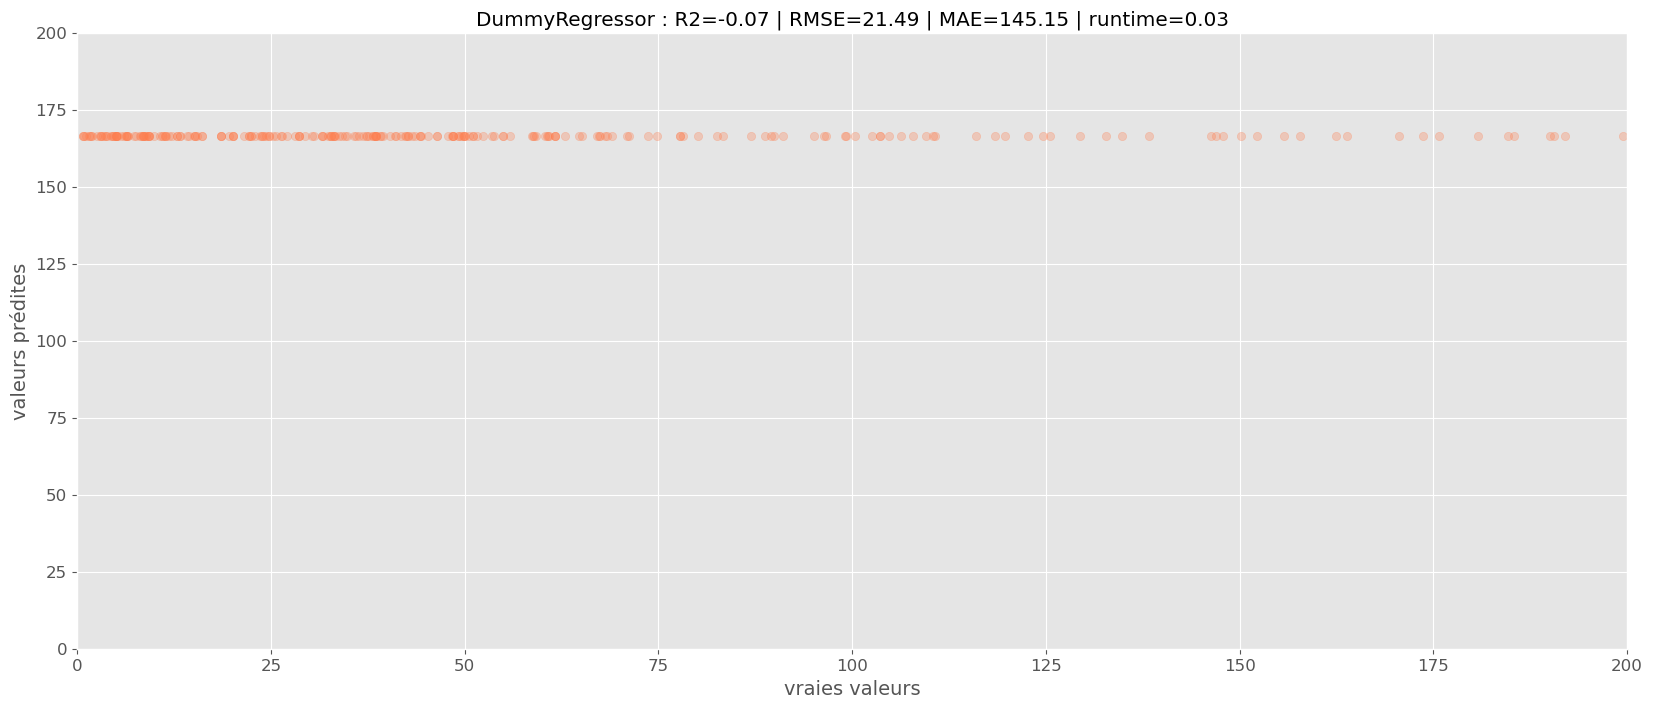

In [109]:
start_time = timeit.default_timer()
strategy = ['mean', 'median']
dum_params = {"strategy": strategy}
dum = dummy.DummyRegressor()
grid_dum = GridSearchCV(
        dum,
        dum_params,
        cv=10,
        refit="r2",
        scoring=score)
                                    
grid_dum.fit(X_train, y_train)
y_pred = grid_dum.predict(X_test)
elapsed = timeit.default_timer() - start_time 

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_dum, 'DummyRegressor')
visualiser_erreur_modele(y_test, y_pred,label)

R2 = 0.02, modèle non performant, prédit toujours la même valeur.

## Modèles régularisés

In [375]:
#Hyperparametres pour chaque type de modèle
alpha_range = np.logspace(-2, 2, 5)
gamma_range = np.logspace(-2, 1, 4)
#alpha_range = [282,283,284]
max_iter = [6,7,8]
l1_ratio = [0.1, 0.5, 1.0, 2.0]
c_range = np.logspace(-2, 2, 6)
selection = ['cyclic', 'random']
normalize = [True, False]
solver = ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]

param_grid = {'alpha': alpha_range, 'gamma': gamma_range, "max_iter": [20, 50,100]}
ridge_params = {'alpha': alpha_range, "solver":solver}
krr_params = {'kernel' : ('linear', 'rbf'), 'alpha': alpha_range, 'gamma': gamma_range}
lasso_params = {'alpha': alpha_range}
elastic_net_params = {'alpha':alpha_range}

param_grid_svr = {'kernel' : ('linear', 'rbf'), 'C' : c_range,
                  'coef0' : [0.01,0.5], 'gamma' : ('auto','scale')}

### Ridge

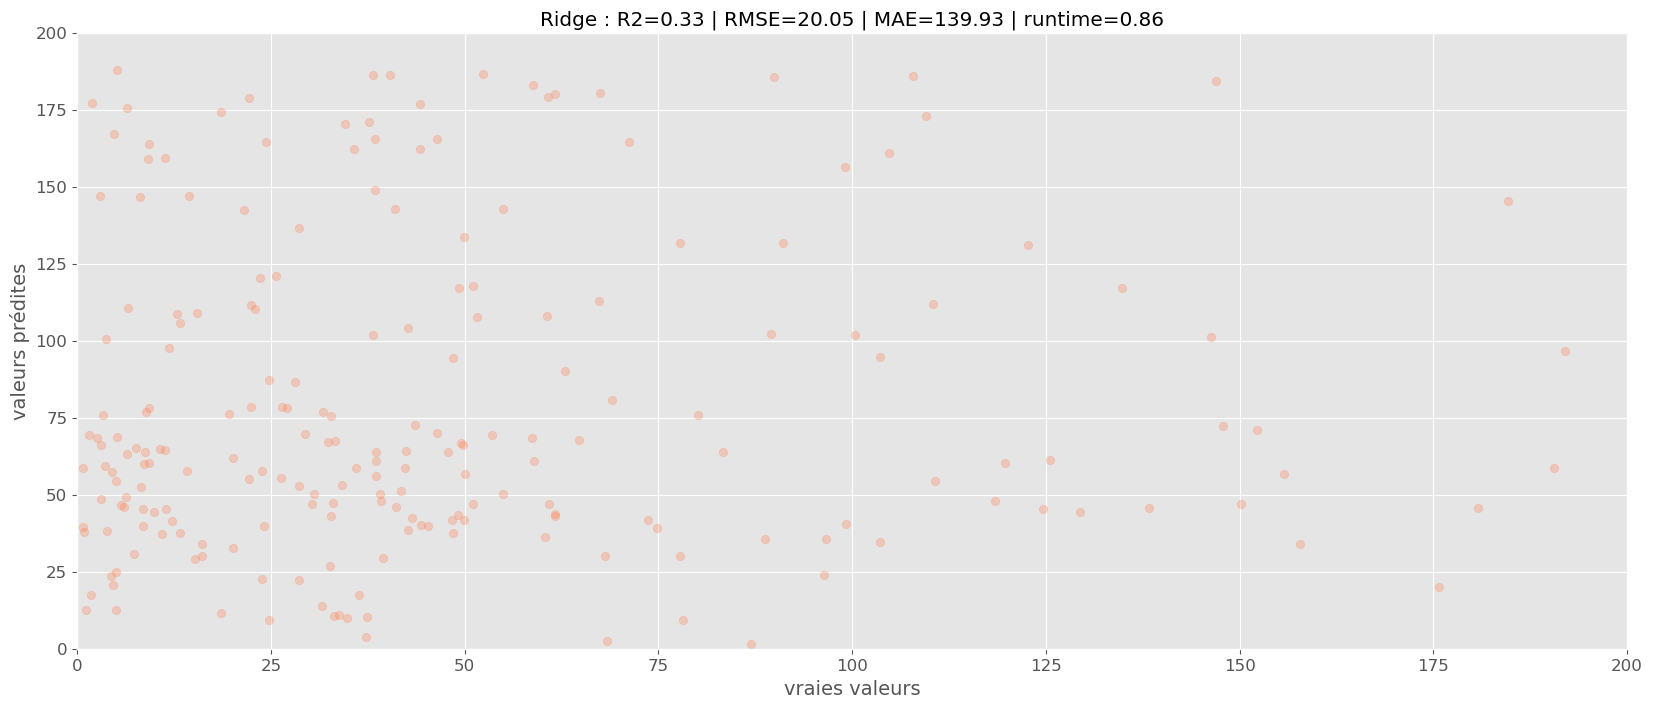

In [376]:
start_time = timeit.default_timer()
grid_rdg = GridSearchCV(
        Ridge(random_state=42),
        ridge_params,
        refit='r2',
        cv=5,  
        scoring= score)
                                    
grid_rdg.fit(X_train, y_train)
y_pred = grid_rdg.predict(X_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_rdg, 'Ridge')

visualiser_erreur_modele(y_test, y_pred,label)

In [377]:
grid_rdg.best_params_

{'alpha': 100.0, 'solver': 'saga'}

### Lasso

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.423e+05, tolerance: 4.031e+04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.589e+04, tolerance: 2.556e+04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.983e+05, tolerance: 3.451e+04


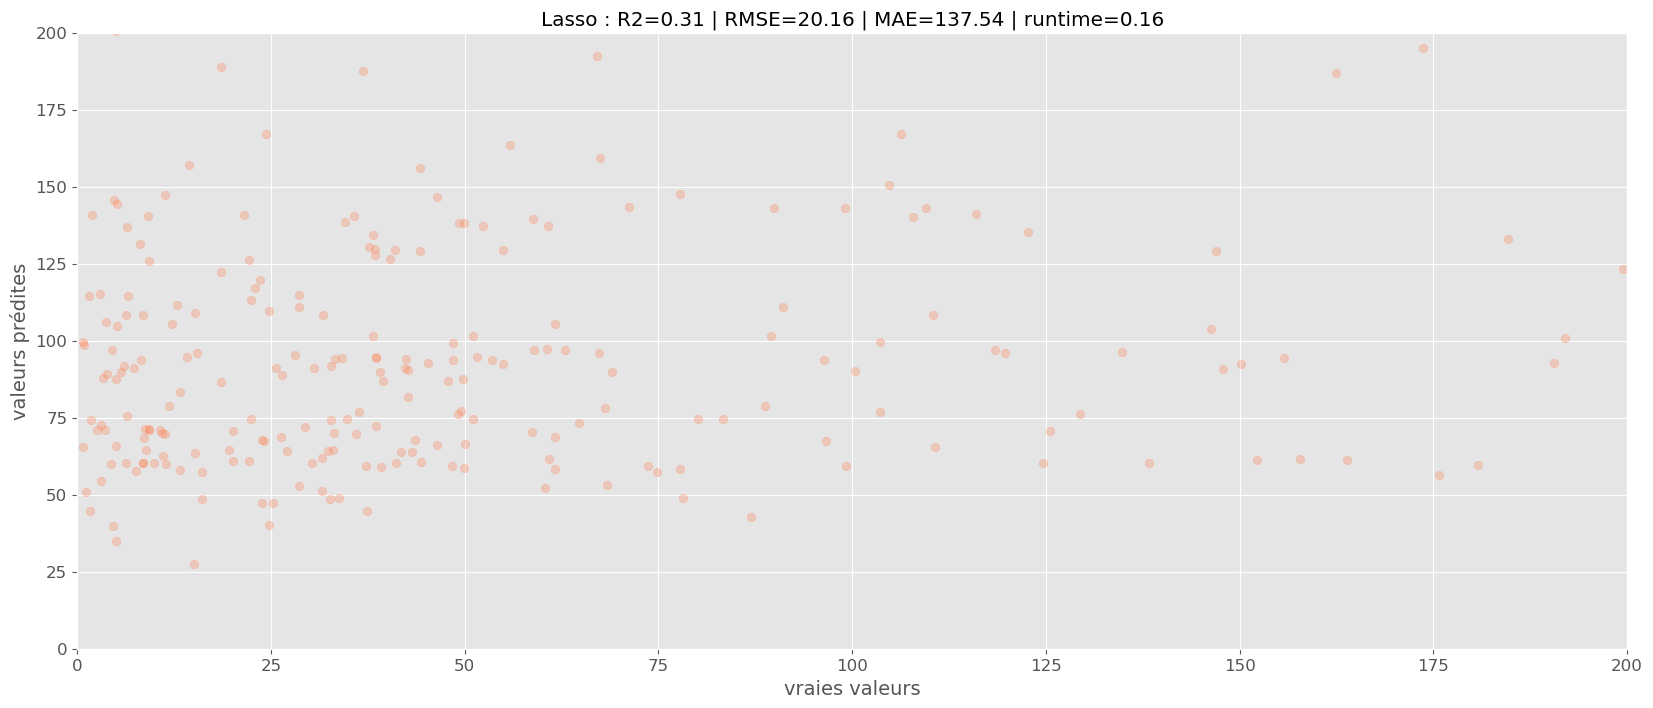

In [378]:
start_time = timeit.default_timer()
grid_lasso = GridSearchCV(
        Lasso(random_state=42),
        lasso_params,
        refit='r2',
        cv=5,  
        scoring= score)
                                    
grid_lasso.fit(X_train, y_train)
y_pred = grid_lasso.predict(X_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_lasso, 'Lasso')

visualiser_erreur_modele(y_test, y_pred,label)

### ElasticNet

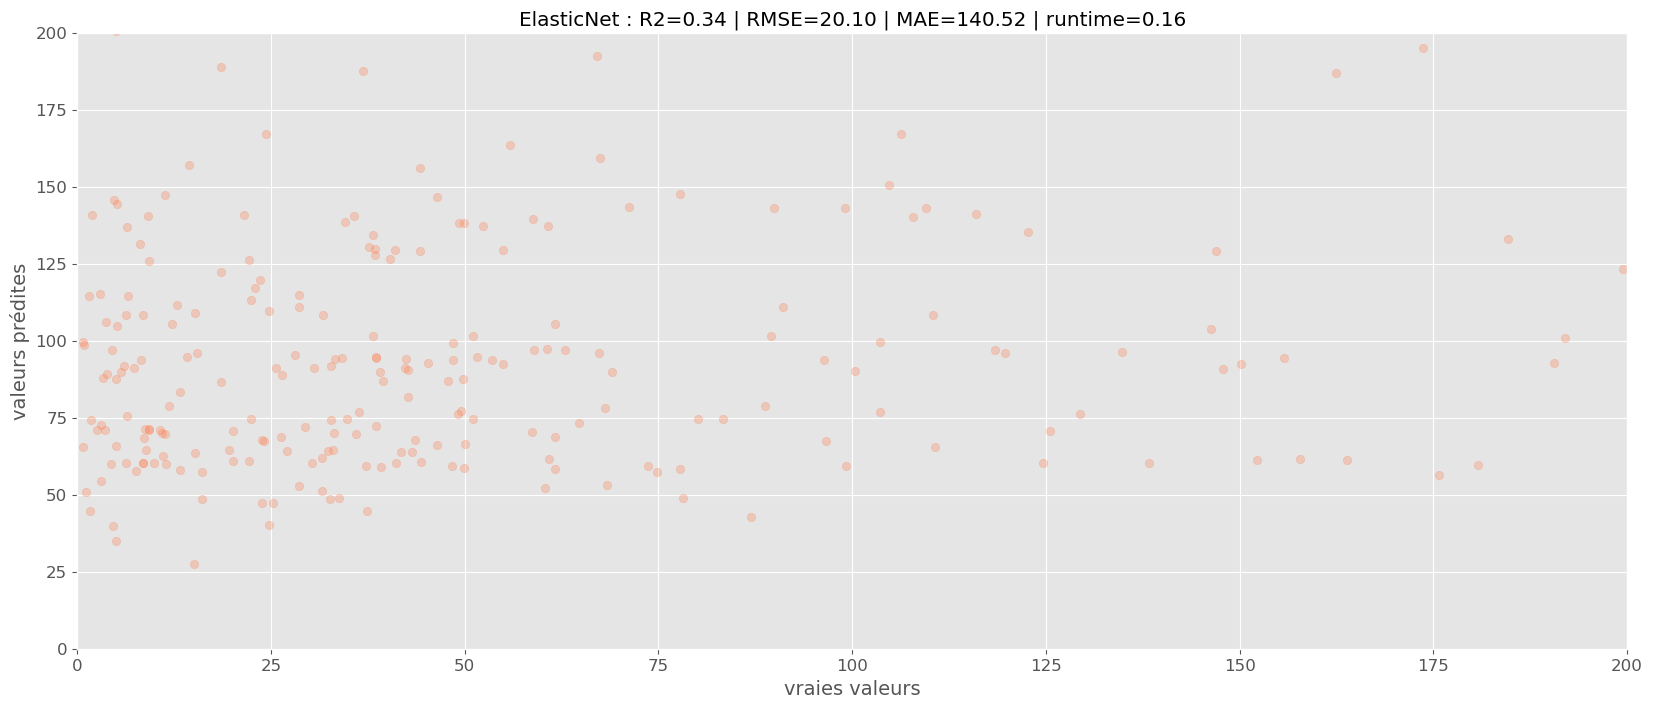

In [379]:
start_time_net = timeit.default_timer()
grid_elestic_net = GridSearchCV(
        ElasticNet(random_state=42),
        elastic_net_params,
        refit='r2',
        cv=5,  
        scoring= score)
                                    
grid_elestic_net.fit(X_train, y_train)
y_hat_net = grid_elestic_net.predict(X_test)
elapsed_time_net = timeit.default_timer() - start_time_net

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_elestic_net, 'ElasticNet')
visualiser_erreur_modele(y_test, y_pred,label)

### Ridgekernel

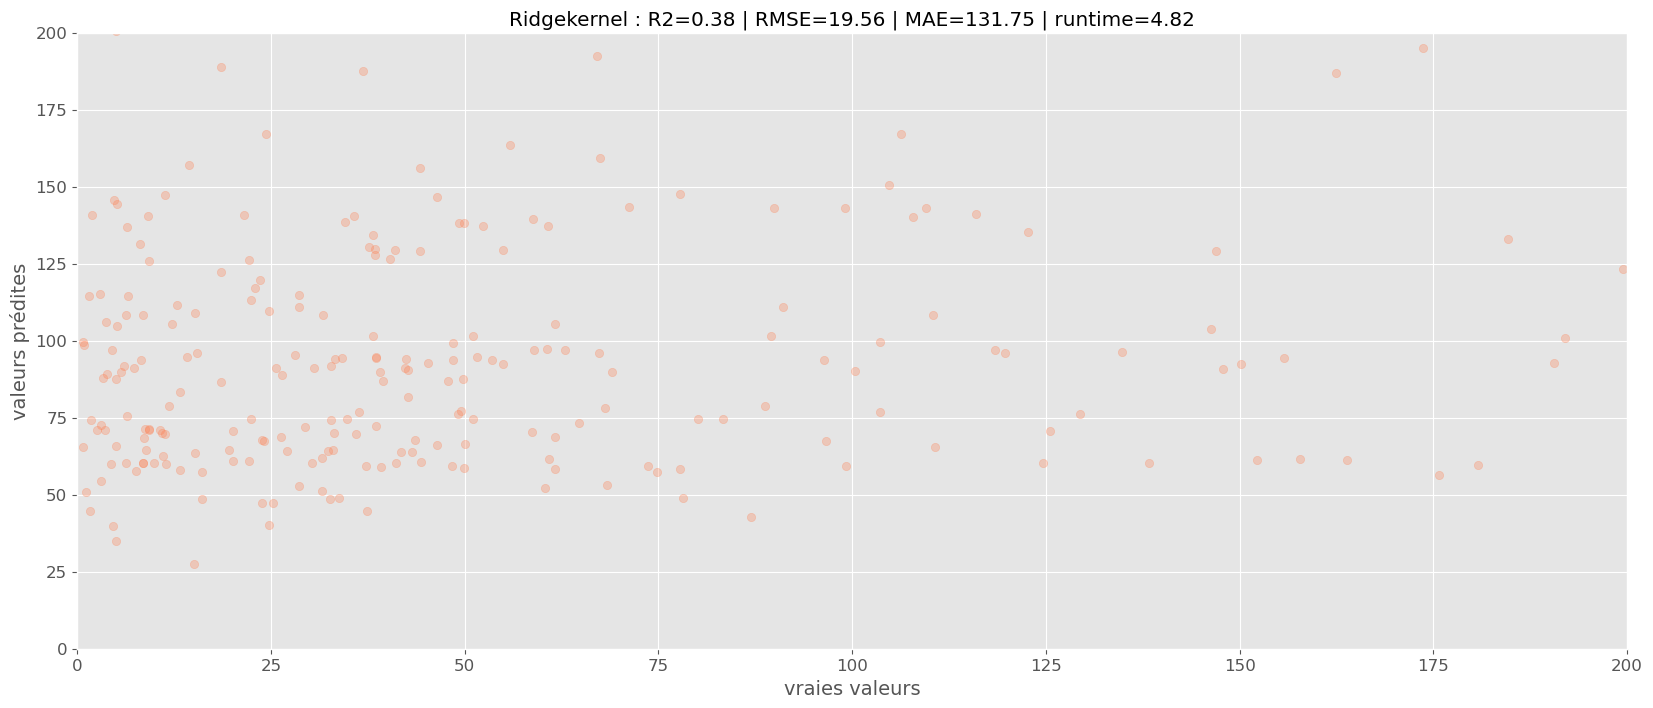

In [380]:
start_time = timeit.default_timer()
grid_krdg = GridSearchCV( # recherche des meilleurs hyperparamètres avec GridSearchGrid
        kernel_ridge.KernelRidge(),
        krr_params,
        cv=5,
        refit="r2",
        scoring=score)
                                    
grid_krdg.fit(X_train, y_train)
y_pred_krdg = grid_krdg.predict(X_test)
elapsed = timeit.default_timer() - start_time 

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_krdg, 'Ridgekernel')
visualiser_erreur_modele(y_test, y_pred,label)

## Modèles SVM

In [381]:
c_range = np.logspace(-2, 2, 6)
gamma_range = np.logspace(-2, 2, 6)

svr_params = [
        {'kernel': ['linear', 'rbf'], 'C': [1.0, 3.0, 30., 100., 300.],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
        }
    ]

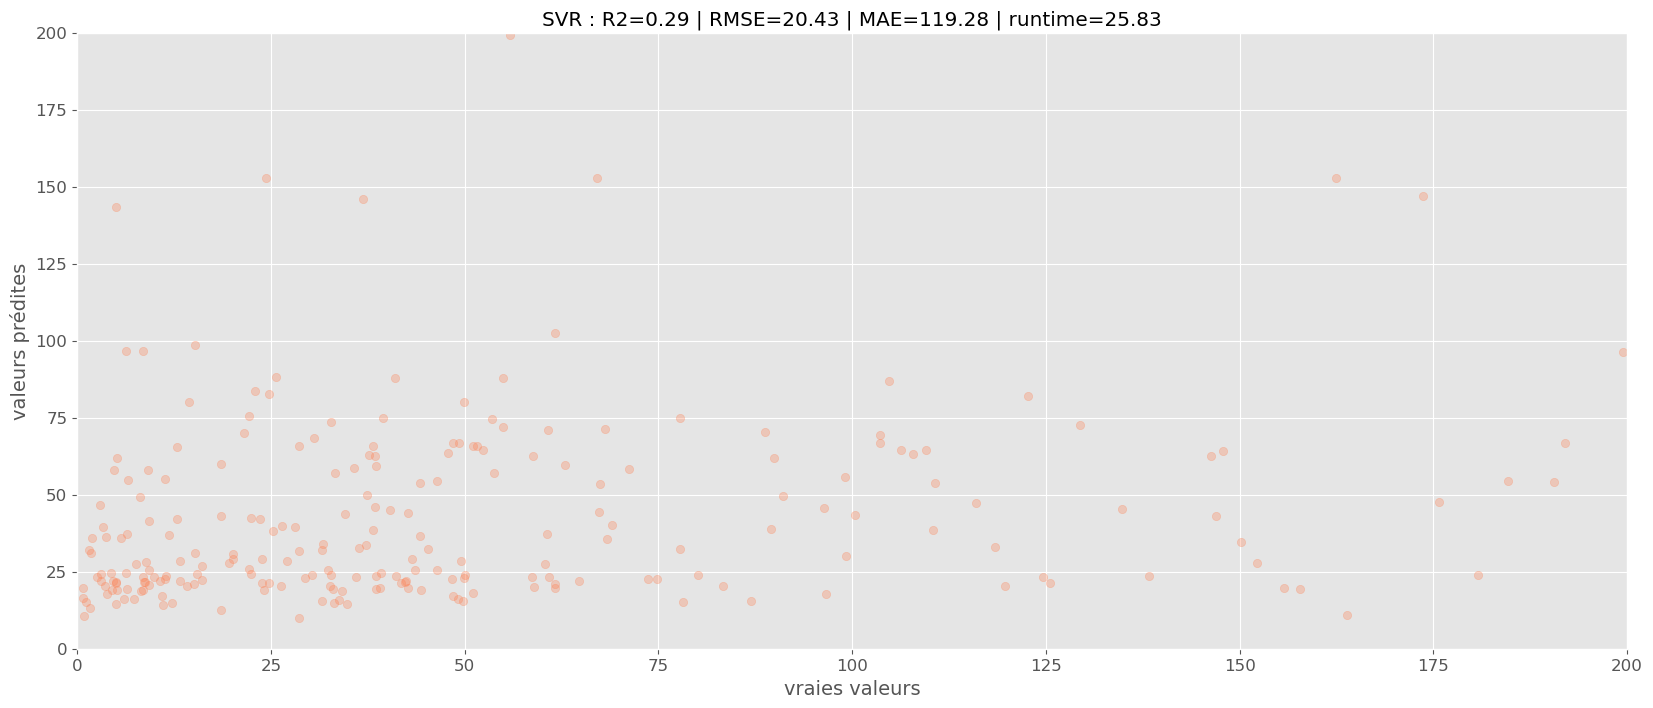

In [382]:
start_time = timeit.default_timer()
grid_svr = GridSearchCV(SVR(),param_grid=svr_params,refit="r2",cv=5,scoring=score)
grid_svr.fit(X_train, y_train)
y_pred = grid_svr.predict(X_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_svr, 'SVR')
visualiser_erreur_modele(y_test, y_pred,label)

### Méthode des k plus proches voisins

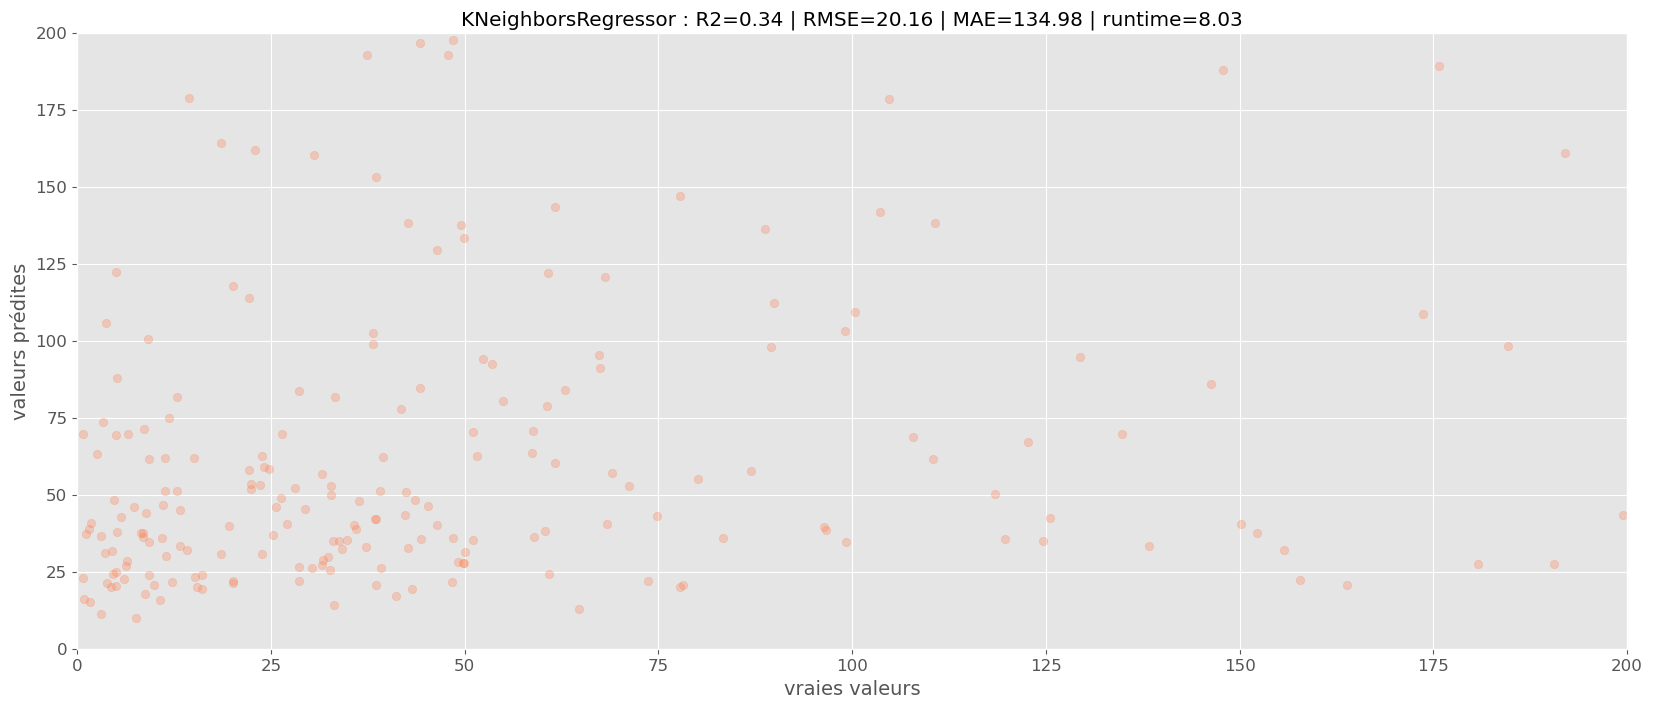

In [396]:
param_grid = {'n_neighbors': [10,12,13,14,15], 'weights': ['uniform', 'distance'], 'p': [14,15]}

start_time = timeit.default_timer()
knn_reg = GridSearchCV(KNeighborsRegressor(),param_grid,refit='r2',cv=5,scoring=score)
knn_reg.fit(X_train, y_train)
y_pred = knn_reg.predict(X_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(knn_reg, 'KNeighborsRegressor')

visualiser_erreur_modele(y_test, y_pred,label)

In [397]:
knn_reg.best_params_

{'n_neighbors': 14, 'p': 14, 'weights': 'distance'}

### RandomForest

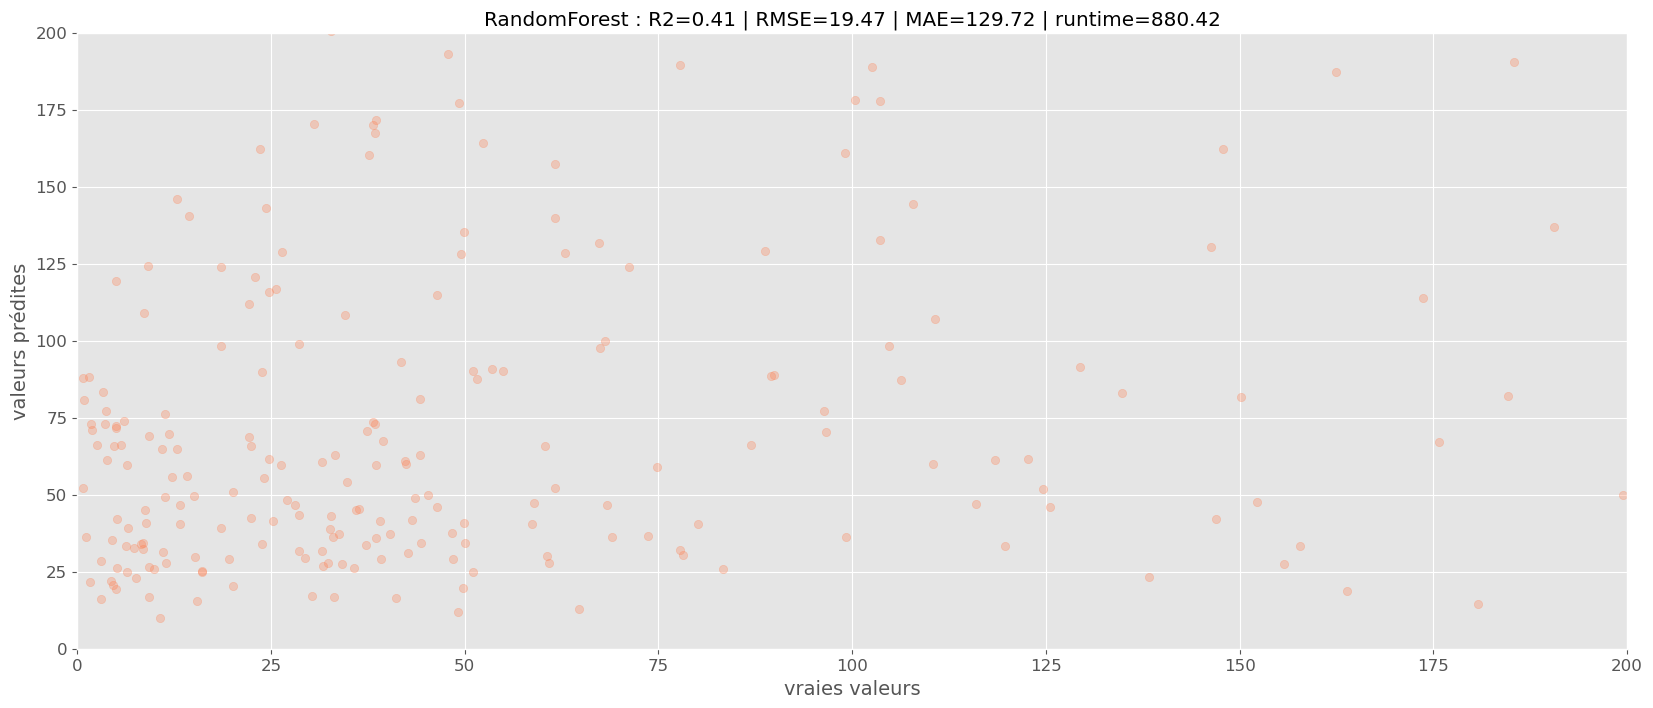

In [417]:
rdf_params = {'bootstrap': [True],
              'n_estimators': invalid value encountered in double_scalars, 
              'max_features': [2,4,5,7,8,9,10,12,15,20]
             }

forest_reg = RandomForestRegressor(random_state=42)
start_time = timeit.default_timer()
rnd_search = GridSearchCV(forest_reg, rdf_params, refit="r2",cv=5, scoring=score)
rnd_search.fit(X_train, y_train)
y_pred = rnd_search.predict(X_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(rnd_search, 'RandomForest')

visualiser_erreur_modele(y_test, y_pred,label)
#print(rnd_search.best_params_)

In [418]:
rnd_search.best_params_

{'bootstrap': True, 'max_features': 12, 'n_estimators': 100}

### Gradient Boosting Regressor

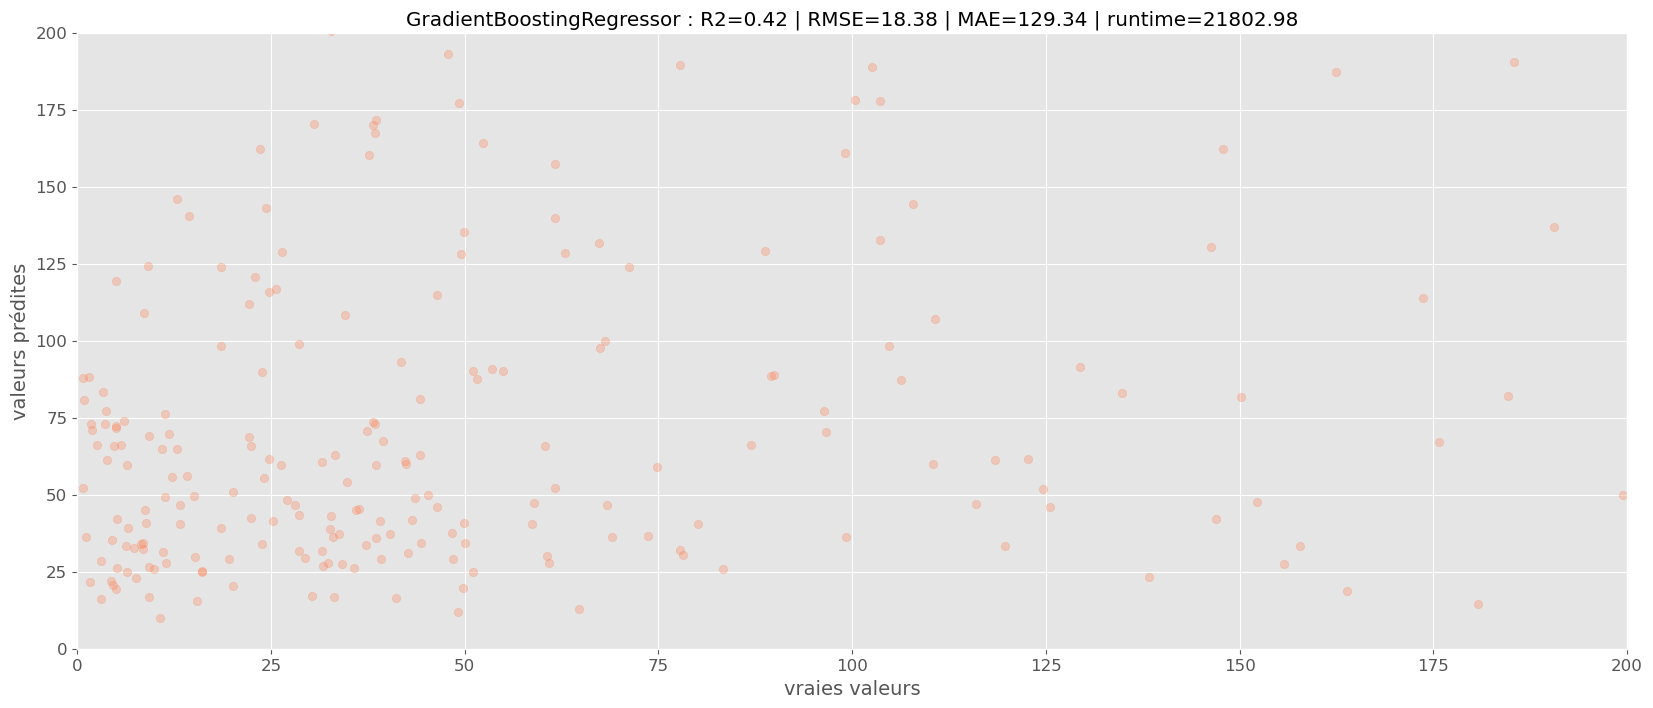

In [419]:
subsample = [0.5,0.9,1.0]
#n_estimators = [100,200]
#max_depth = [10,15]

n_estimators = [50,100,150,200,250,300,350,400,450,500,550,600,700,800,850,900,950,1000,1050,1100]
max_depth = [5,10,15,20,25,30,35,40]


#learning_range = np.arange(0.01,0.11,0.01)
learning_range = np.arange(0.05,0.1,0.01)

param_grid = {'max_depth':max_depth,'learning_rate':learning_range,'subsample':subsample,'n_estimators':n_estimators}

start_time = timeit.default_timer()
grid_xboost = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid,
        cv=5,
        refit="r2",
        scoring=score)
                            
grid_xboost.fit(X_train, y_train)
y_pred_xboost = grid_xboost.predict(X_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetricsGridSearchCV(grid_xboost, 'GradientBoostingRegressor')

visualiser_erreur_modele(y_test, y_pred,label)

In [426]:
grid_GBR.best_params_

{'learning_rate': 0.04, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.2}

### Résultats de chaque modèle

In [420]:
mesures_principales

,DummyRegressor,Ridge,Lasso,ElasticNet,Ridgekernel,SVR,KNeighborsRegressor,RandomForest,GradientBoostingRegressor
R2,-0.07,0.33,0.31,0.34,0.38,0.29,0.34,0.41,0.42
RMSE,21.49,20.05,20.16,20.10,19.56,20.43,20.16,19.47,18.38
MAE,145.15,139.93,137.54,140.52,131.75,119.28,134.98,129.72,129.34
runtime(en seconde),0.03,0.86,0.16,0.16,4.82,25.83,8.03,880.42,21802.98


In [421]:
R2 = mesures_principales.loc['R2'].astype(np.float64)
RMSE = mesures_principales.loc['RMSE'].astype(np.float64)
MAE = mesures_principales.loc['MAE'].astype(np.float64)

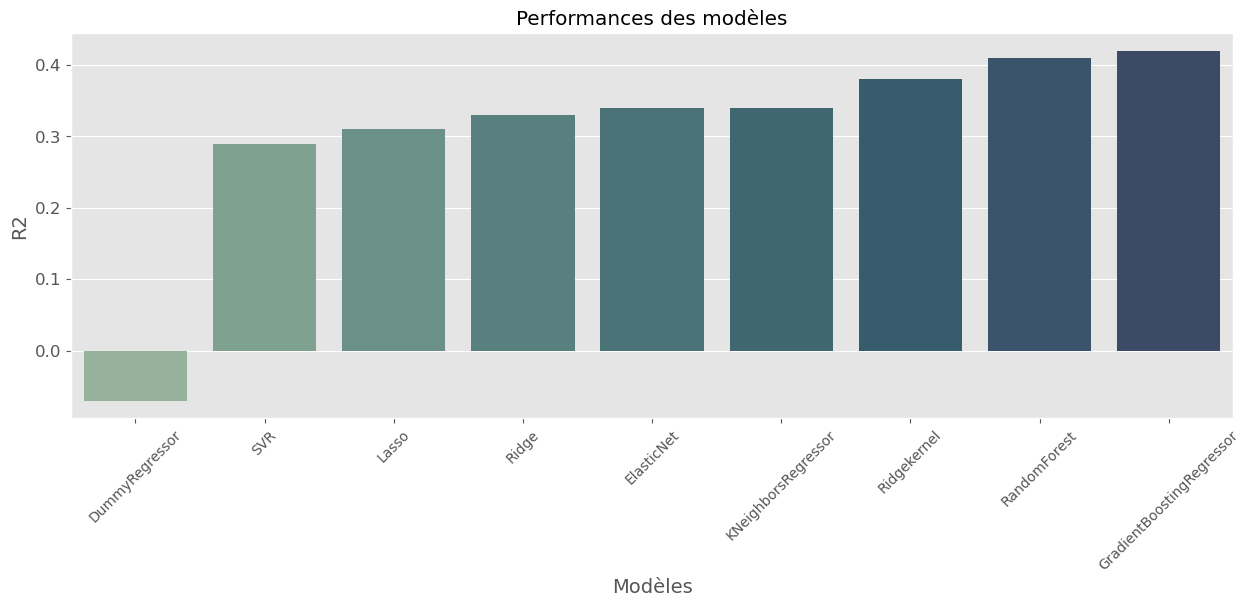

In [422]:
visualiser_mesure_models(R2, 'R2')

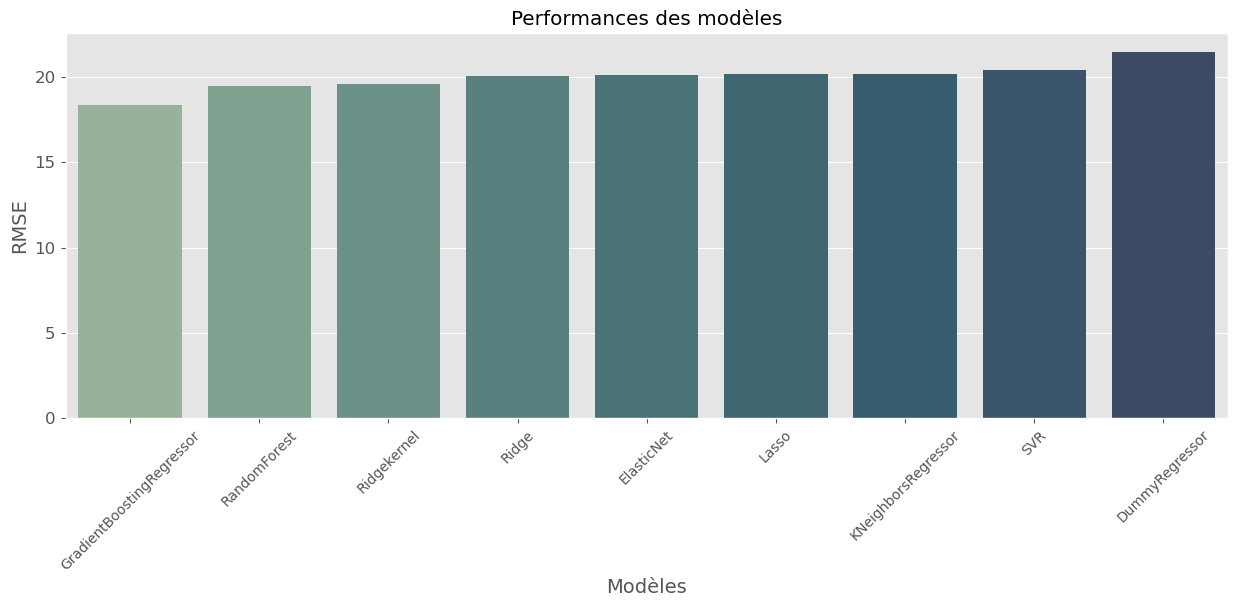

In [423]:
visualiser_mesure_models(RMSE, 'RMSE')

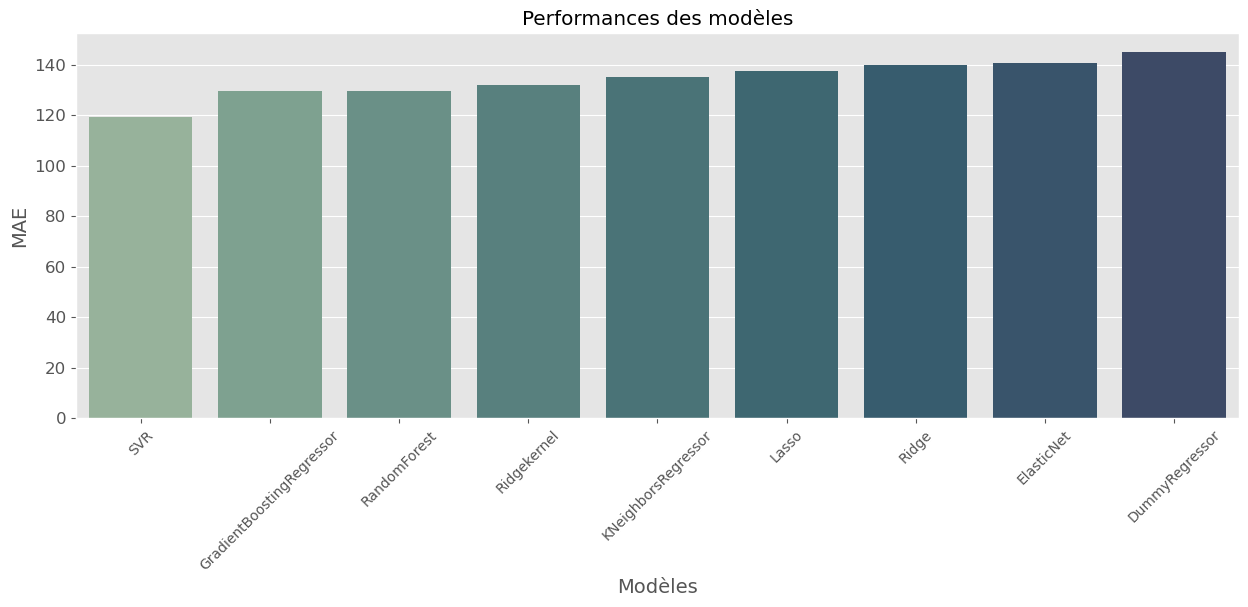

In [424]:
visualiser_mesure_models(MAE,'MAE')

In [425]:
mesures_principales.to_csv('data/mesures_principales.csv')

In [427]:
best_model = grid_GBR.best_estimator_
best_model_curve = grid_GBR.best_estimator_
best_model_ess = grid_GBR.best_estimator_
best_model_log = grid_GBR.best_estimator_

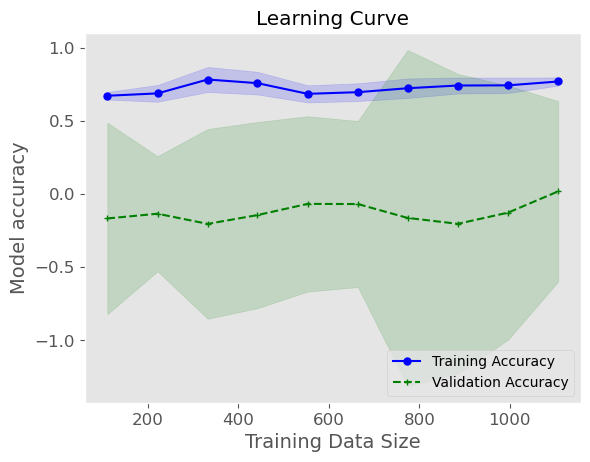

In [428]:
curve_learning(best_model_curve,X_train,y_train)

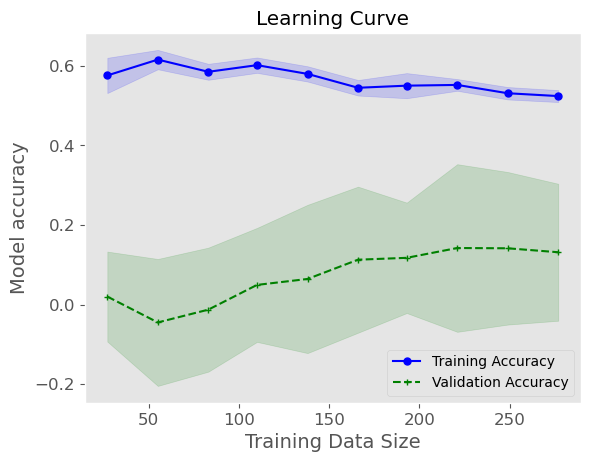

In [451]:
curve_learning(best_model_curve,X_test,y_test)

divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encoun

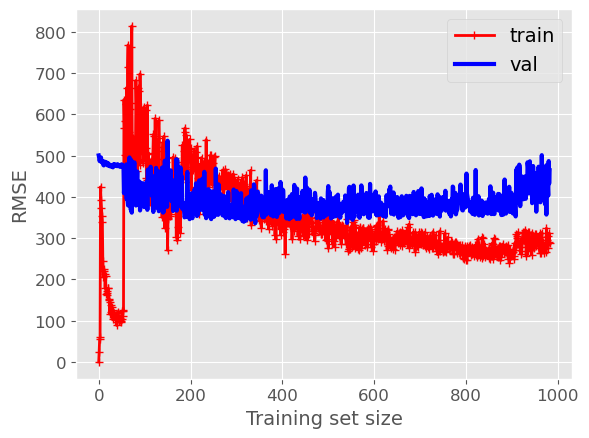

In [430]:
plot_learning_curves(best_model, X_train, y_train)

divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encoun

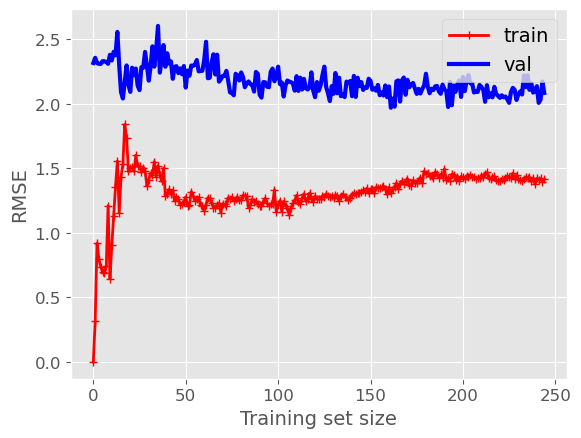

In [450]:
plot_learning_curves(best_model, X_test, y_test)

### Partie 2 : Mesure de l'importance des variables

In [431]:
# explainer
explainer = shap.Explainer(best_model.predict, X_test)
# Calcule les valeurs SHAP
shap_values = explainer(X_test)

- Evaluation des valeurs SHAP

- Pour l'analyse de l'effet global des caractéristiques, nous pouvons utiliser les graphiques suivants

Diagramme à barres

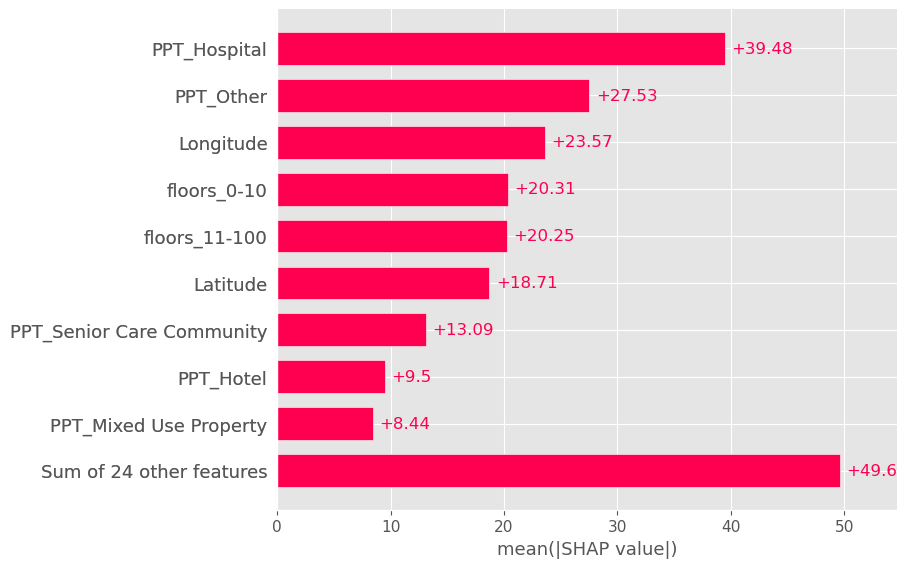

In [432]:
# Globale
shap.plots.bar(shap_values)

- Ici, les caractéristiques sont classées de l'effet le plus élevé au plus faible sur la prédiction. Il prend en compte la valeur SHAP absolue, donc peu importe si la fonctionnalité affecte la prédiction de manière positive ou négative.

Tracé récapitulatif : abeilles chaudes

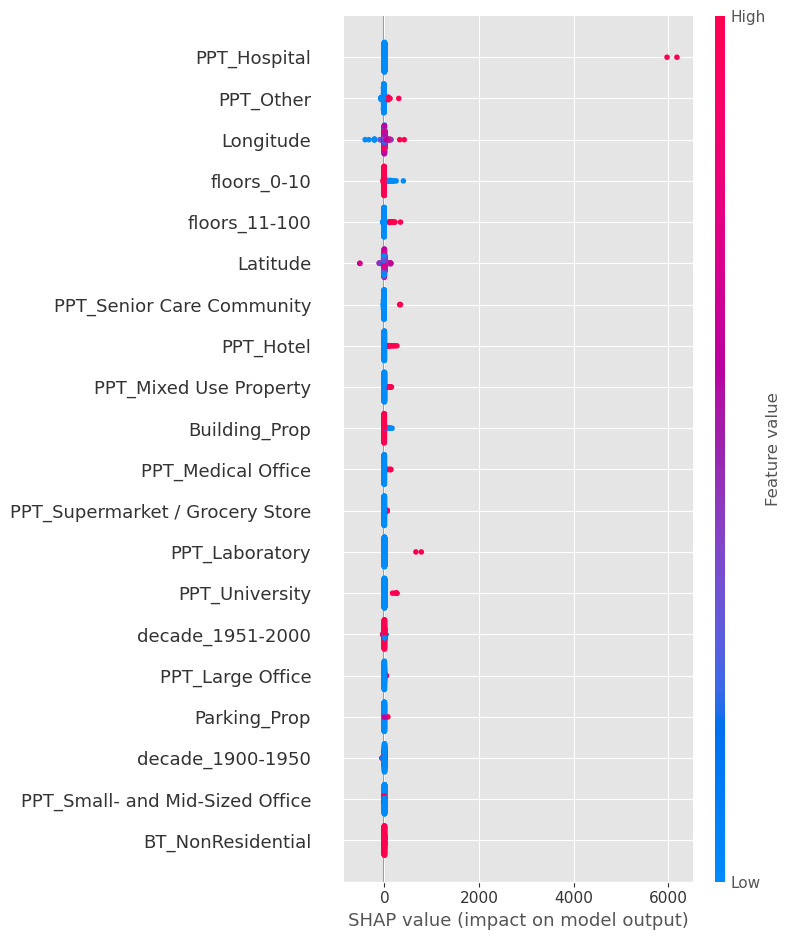

In [433]:
shap.summary_plot(shap_values)

#shap.plots.beeswarm(shap_values)

Sur le beeswarm, les caractéristiques sont également classées en fonction de leur effet sur la prédiction, mais nous pouvons également voir comment les valeurs supérieures et inférieures de la caractéristique affecteront le résultat.

Tous les petits points sur le graphique représentent une seule observation. L'axe horizontal représente la valeur SHAP, tandis que la couleur du point nous indique si cette observation a une valeur supérieure ou inférieure, par rapport aux autres observations.

Dans cet exemple, des latitudes et longitudes plus élevées ont un impact négatif sur la prédiction, tandis que des valeurs plus basses ont un impact positif.

Intrigue récapitulative : violon

Une autre façon de voir les informations du beeswarm est d'utiliser le tracé du violon :

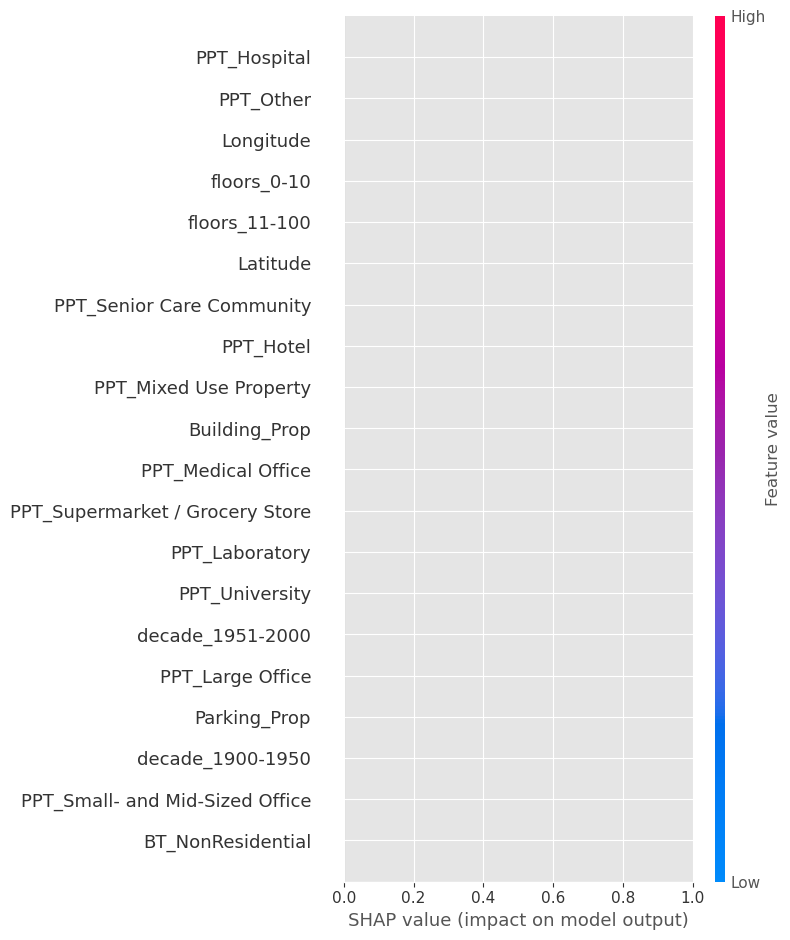

In [434]:
shap.summary_plot(shap_values, plot_type='violon')

Pour l'analyse des effets locaux, par instance, nous pouvons utiliser les graphiques suivants sur des observations uniques (dans les exemples ci-dessous, j'ai utilisé shap_values[0]).

Graphique à barres local

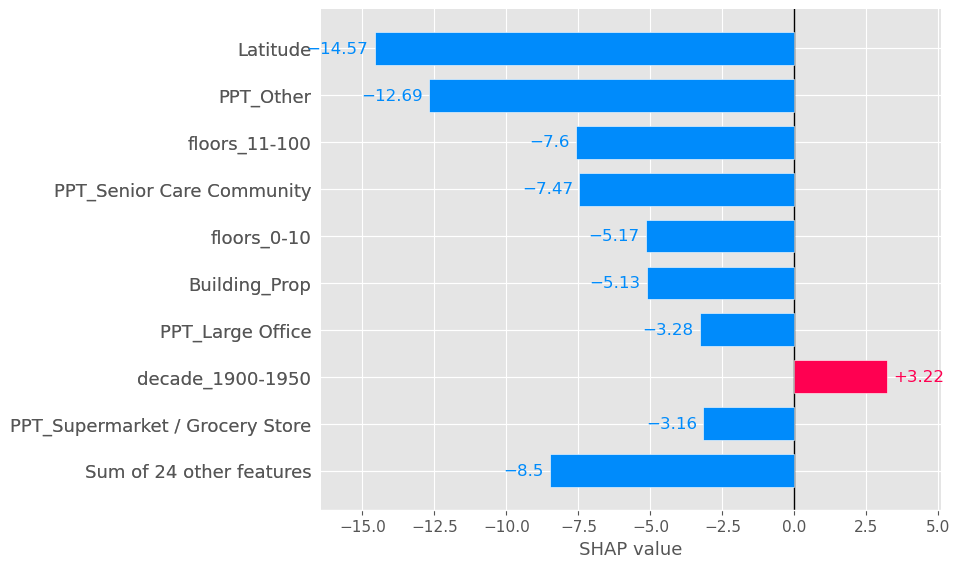

In [435]:
# Locale
shap.plots.bar(shap_values[0])

Ce graphique nous montre quelles sont les principales caractéristiques affectant la prédiction d'une seule observation, et l'ampleur de la valeur SHAP pour chaque caractéristique.

Terrain en cascade

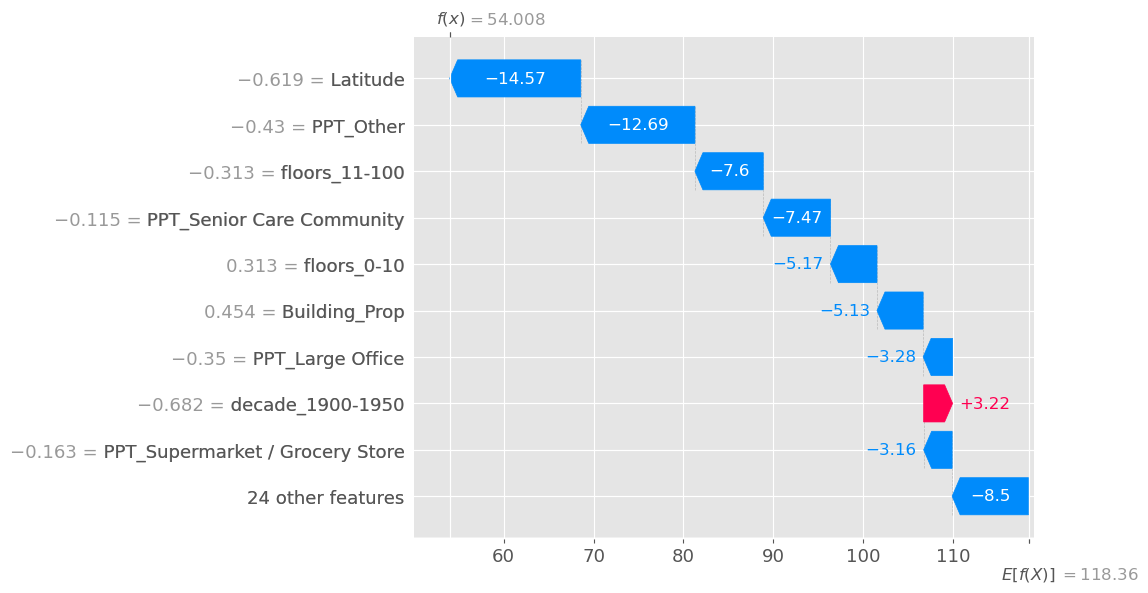

In [436]:
shap.plots.waterfall(shap_values[0])

Le tracé en cascade contient les mêmes informations, représentées de manière différente. Ici, nous pouvons voir comment la somme de toutes les valeurs SHAP est égale à la différence entre la prédiction f(x) et la valeur attendue E[f(x)].

Tracé de force

In [437]:
#shap.plots.force(shap_values[0])

Le diagramme de force est une autre façon de voir l'effet de chaque caractéristique sur la prédiction, pour une observation donnée. Dans ce graphique, les valeurs SHAP positives sont affichées sur le côté gauche et les valeurs négatives sur le côté droit, comme si elles se faisaient concurrence. La valeur en surbrillance est la prédiction pour cette observation

On constate que les valeurs élevées de la variable **PropertyGFAParking** ont une influence positive

### Partie 3 : Influence de la variable **EneergieStarScore**

-On ré-entraine le meilleur estimateur en introduisant la variable **EnergieScorStar**

In [442]:
start_time = timeit.default_timer()
best_model_ess.fit(X_ESS_train, y_ESS_train)
y_pred = best_model_ess.predict(X_ESS_test)
elapsed = timeit.default_timer() - start_time

best_R2, best_RMSE, best_MAE, label = getMetrics(y_ESS_test, y_pred, 'GradientBoostingRegressor_ESS')

In [443]:
mesures_principales[['GradientBoostingRegressor','GradientBoostingRegressor_ESS']]

,GradientBoostingRegressor,GradientBoostingRegressor_ESS
R2,0.42,0.67
RMSE,18.38,17.50
MAE,129.34,134.88
runtime(en seconde),21802.98,0.07


- La variable **EneergieStarScore**  améliore légérement les performances de notre modèle

### Partie 4 : Entraînement du meilleur estimateur avec y_TotalGHGEmissions_log2

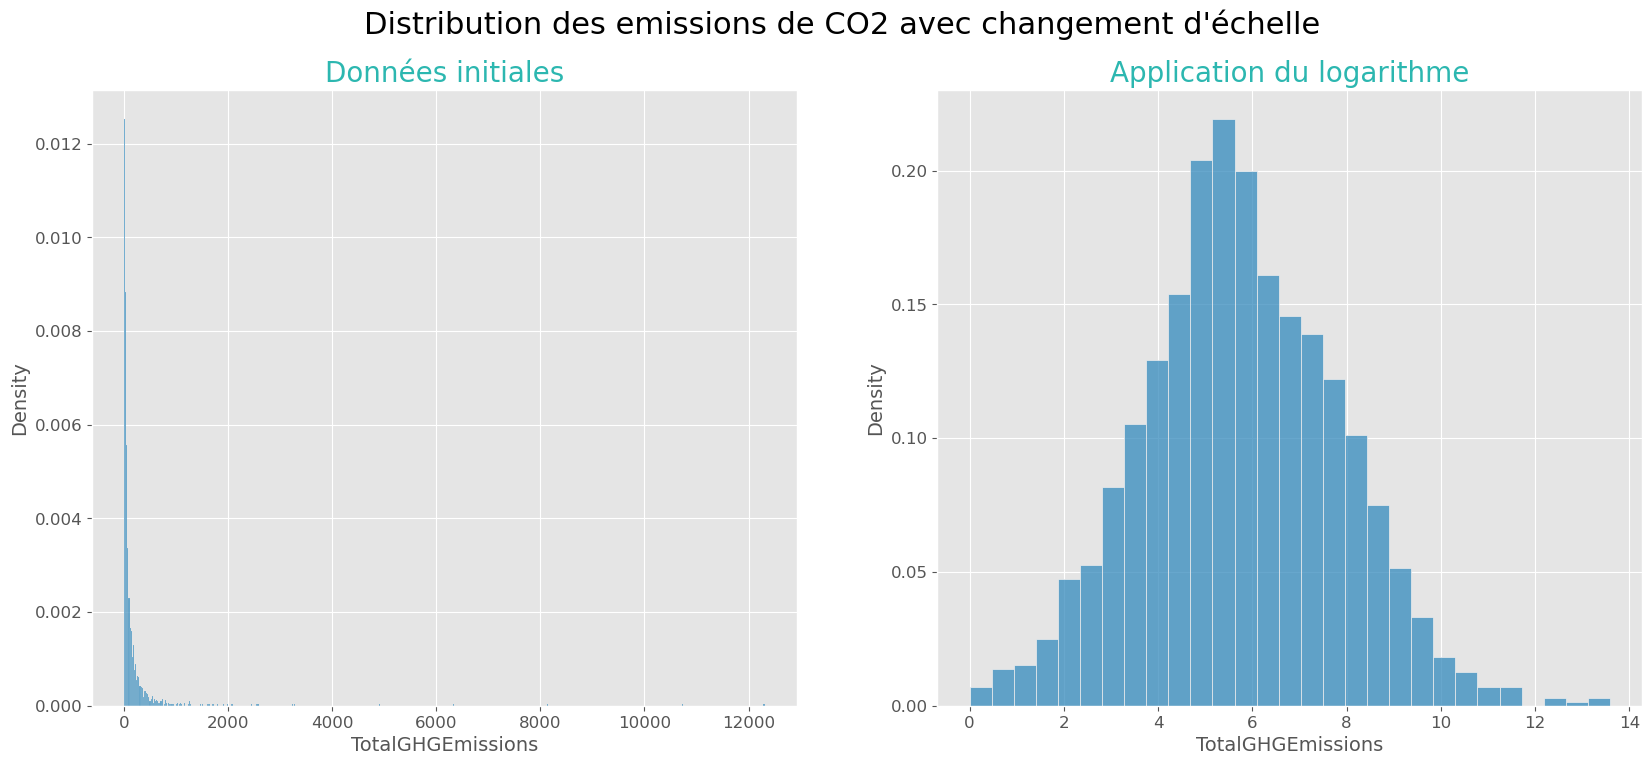

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=y_TotalGHGEmissions, stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0', fontsize=20)
sns.histplot(data=y_TotalGHGEmissions_log2, stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0', fontsize=20)
plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontsize=22)
plt.show()

- En passant les données à l'échelle logarithmique, nous obtenons une distribution normale des données à prédire

In [446]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_TotalGHGEmissions_log2, test_size=0.2, random_state=42)

In [447]:
start_time = timeit.default_timer()
best_model_log.fit(X_train, y_train)
y_pred = best_model_log.predict(X_test)
elapsed = timeit.default_timer() - start_time

R2, RMSE, MAE, label = getMetrics(y_test, y_pred, 'GradientBoostingRegressor_LOG')

#visualiser_erreur_modele(y_test, y_pred, label)

In [448]:
mesures_principales[['GradientBoostingRegressor','GradientBoostingRegressor_LOG']]

,GradientBoostingRegressor,GradientBoostingRegressor_LOG
R2,0.42,0.26
RMSE,18.38,1.34
MAE,129.34,1.45
runtime(en seconde),21802.98,0.06


- On constate une forte amélioration de notre modèle

In [449]:
mesures_principales.to_csv('data/all_mesures_principales.csv')

## Fin